# Дипломный проект 

"Анализ данных США 1970х гг. на предмет определения социального развития"  

Целью работы является определение наиболее благоприятных штатов для жизни по следующим признакам:

1) Высокий доход

2) Образованность

3) Благополучная криминальная обстановка 

4) Высокая продолжительность жизни

5) Благоприятные климатические условия

Параллельно определим и те штаты, которые испытывают проблемы с социальным развитием.


Описание датасета с пояснениями по каждой колонке:

Context
In this problem, we will be examining the "state" dataset, which has data from the 1970s on all fifty US states. For each state, the dataset includes the population, per capita income, illiteracy rate, murder rate, high school graduation rate, average number of frost days, area, latitude and longitude, division the state belongs to, region the state belongs to, and two-letter abbreviation.

Content
This dataset has 50 observations (one for each US state) and the following 15 variables:

Population (Население) - численность населения в штате в 1975 г. (в тыс.).

Income (Доход) - доход на душу населения в 1974 г. (за год)

Illiteracy (Неграмотность) - уровень неграмотности в 1970 г. (в процентах к населению). 

Life.Exp (Ожидаемая продолжительность жизни) - ожидаемая продолжительность жизни в годах жителей штата в 1970 г. 

Murder (убийства) - количество убитых (как умышленно, так и без умысла) на 100 000 населения в 1976 г.

HS.Grad - - процент выпускников средней школы в 1970 г. 

Frost - среднее число дней с минимальной температурой ниже нуля с 1931–1960 гг. в столице или крупном городе 
штата.

Area - площадь суши (в квадратных милях) штата.

state.abb - аббревиатура для каждого штата.

state.area - площадь каждого штата (в квадратных милях). 

x - долгота центра штата. 

y - широта центра штата.

state.division - округ, к которому принадлежит каждый штат (New England, Middle Atlantic, South Atlantic, East South Central, West South Central, East North Central, West North Central, Mountain, or Pacific). 

state.name - полное название штата. 

state.region - регион, к которому относится каждый штат (Northeast, South, North Central, or West).


In [79]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import argparse  
from pandas.io import gbq

In [80]:
data = pd.read_csv('/home/anastacia/python_netology/statedata.csv')
data.head()

Population  Income  Illiteracy  Life.Exp  Murder  HS.Grad  Frost    Area  \
0        3615    3624         2.1     69.05    15.1     41.3     20   50708   
1         365    6315         1.5     69.31    11.3     66.7    152  566432   
2        2212    4530         1.8     70.55     7.8     58.1     15  113417   
3        2110    3378         1.9     70.66    10.1     39.9     65   51945   
4       21198    5114         1.1     71.71    10.3     62.6     20  156361   

  state.abb  state.area         x        y      state.division  state.name  \
0        AL       51609  -86.7509  32.5901  East South Central     Alabama   
1        AK      589757 -127.2500  49.2500             Pacific      Alaska   
2        AZ      113909 -111.6250  34.2192            Mountain     Arizona   
3        AR       53104  -92.2992  34.7336  West South Central    Arkansas   
4        CA      158693 -119.7730  36.5341             Pacific  California   

  state.region  
0        South  
1         West  
2         West  
3        South  
4         West

In [81]:
#чтобы в названиях колонок не было проблем с точками (в BigQuery особенно) - переименуем
data = data.rename({'Life.Exp':'Life_Exp', 'HS.Grad':'HS_Grad', 'state.division':'state_division', 'state.name':'state_name', 'state.abb':'state_abb', 'state.area':'state_area', 'state.region':'state_region'}, axis='columns', inplace=False)


In [82]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 15 columns):
Population        50 non-null int64
Income            50 non-null int64
Illiteracy        50 non-null float64
Life_Exp          50 non-null float64
Murder            50 non-null float64
HS_Grad           50 non-null float64
Frost             50 non-null int64
Area              50 non-null int64
state_abb         50 non-null object
state_area        50 non-null int64
x                 50 non-null float64
y                 50 non-null float64
state_division    50 non-null object
state_name        50 non-null object
state_region      50 non-null object
dtypes: float64(6), int64(5), object(4)
memory usage: 5.9+ KB


Как видим, датасет не содержит нулевых значений, цифровые значения указаны в числовых форматах.

Для последующего анализа, датасет разделим по схеме "звезда" по четырем следующим категориям: state, money, climate, criminal. И для удобства понимания изобразим это в виде схемы.

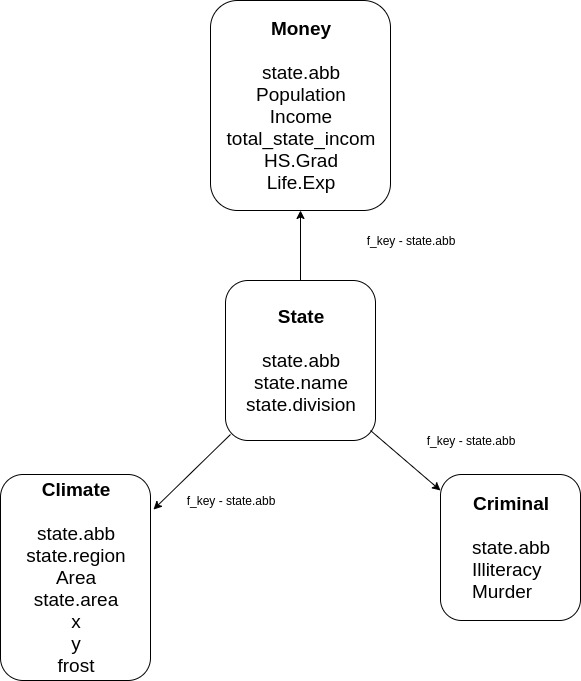

In [83]:
from IPython.display import Image 
Image('/home/anastacia/python_netology/Star.jpg', width=300, height=300) 

In [84]:
#добавим колонку "общий доход по штату (перемножаем население на подушевный доход)"
data['total_state_income'] = data['Population']*data['Income']
data.head()

Population  Income  Illiteracy  Life_Exp  Murder  HS_Grad  Frost    Area  \
0        3615    3624         2.1     69.05    15.1     41.3     20   50708   
1         365    6315         1.5     69.31    11.3     66.7    152  566432   
2        2212    4530         1.8     70.55     7.8     58.1     15  113417   
3        2110    3378         1.9     70.66    10.1     39.9     65   51945   
4       21198    5114         1.1     71.71    10.3     62.6     20  156361   

  state_abb  state_area         x        y      state_division  state_name  \
0        AL       51609  -86.7509  32.5901  East South Central     Alabama   
1        AK      589757 -127.2500  49.2500             Pacific      Alaska   
2        AZ      113909 -111.6250  34.2192            Mountain     Arizona   
3        AR       53104  -92.2992  34.7336  West South Central    Arkansas   
4        CA      158693 -119.7730  36.5341             Pacific  California   

  state_region  total_state_income  
0        South            13100760  
1         West             2304975  
2         West            10020360  
3        South             7127580  
4         West           108406572

Посмотрим средние значения по округам и регионам. 

In [85]:
data.groupby(['state_region']).mean()

Population       Income  Illiteracy   Life_Exp     Murder  \
state_region                                                                
North Central  4803.000000  4611.083333    0.700000  71.766667   5.275000   
Northeast      5495.111111  4570.222222    1.000000  71.264444   4.722222   
South          4208.125000  4011.937500    1.737500  69.706250  10.581250   
West           2915.307692  4702.615385    1.023077  71.234615   7.215385   

                 HS_Grad       Frost        Area     state_area           x  \
state_region                                                                  
North Central  54.516667  138.833333   62652.000   63794.166667  -92.562783   
Northeast      53.966667  132.777778   18141.000   18817.000000  -72.756411   
South          44.343750   64.625000   54605.125   56222.250000  -85.174487   
West           62.000000  102.153846  134463.000  137227.692308 -114.988769   

                       y  total_state_income  
state_region                                  
North Central  42.171567        2.242957e+07  
Northeast      42.535956        2.638790e+07  
South          34.610344        1.734057e+07  
West           40.606854        1.428529e+07

Становится очевидно, что основные проблемы в южном регионе. Благополучный регион - север.

In [86]:
data.groupby(['state_division']).mean()

Population       Income  Illiteracy   Life_Exp  \
state_division                                                         
East North Central   8189.000000  4669.000000    0.800000  70.990000   
East South Central   3379.000000  3563.750000    1.950000  69.337500   
Middle Atlantic     12423.000000  4863.000000    1.166667  70.636667   
Mountain             1203.125000  4402.250000    0.950000  70.947500   
New England          2031.166667  4423.833333    0.916667  71.578333   
Pacific              5654.800000  5183.200000    1.140000  71.694000   
South Atlantic       4118.250000  4355.250000    1.500000  69.526250   
West North Central   2384.428571  4569.714286    0.628571  72.321429   
West South Central   5217.000000  3773.500000    2.000000  70.435000   

                       Murder    HS_Grad       Frost           Area  \
state_division                                                        
East North Central   7.780000  53.200000  129.400000   48820.200000   
East South Central  12.300000  40.650000   58.750000   44745.500000   
Middle Atlantic      7.400000  51.800000  107.666667   33439.333333   
Mountain             7.187500  61.412500  135.000000  107005.875000   
New England          3.383333  55.050000  145.333333   10491.833333   
Pacific              7.260000  62.940000   49.600000  178394.400000   
South Atlantic       9.775000  45.725000   75.625000   33363.625000   
West North Central   3.485714  55.457143  145.571429   72531.857143   
West South Central  10.475000  45.275000   48.500000  106947.750000   

                       state_area           x          y  total_state_income  
state_division                                                                
East North Central   49656.600000  -86.547160  41.609960        3.872416e+07  
East South Central   45491.000000  -86.945200  34.583525        1.221769e+07  
Middle Atlantic      34248.333333  -75.609500  41.335567        5.993156e+07  
Mountain            107985.875000 -110.220875  39.878013        5.341869e+06  
New England          11101.333333  -71.329867  43.136150        9.616066e+06  
Pacific             184014.600000 -122.617400  41.773000        2.859477e+07  
South Atlantic       34838.375000  -79.316225  35.398088        1.823701e+07  
West North Central   73892.428571  -96.859657  42.572714        1.079057e+07  
West South Central  109721.250000  -95.120300  33.061675        2.067056e+07

По округам - проблемы зашкаливают в штатах на юго-востоке страны (East South Central) и южной атлантике (South Atlantic). Благополучно, к примеру, на побережье Тихого океана (Pacific), северо-западе (West North Central). 

Чтобы рассмотреть каждый штат на предмет благополучия, разделим датасет, как приведено выше на схеме. И, заодно, сохраним данные в файл csv. 

In [87]:
money = data[['state_abb', 'Population', 'Income', 'total_state_income', 'HS_Grad', 'Life_Exp']]
money.to_csv('money.csv', index=False)
money.head()

state_abb  Population  Income  total_state_income  HS_Grad  Life_Exp
0        AL        3615    3624            13100760     41.3     69.05
1        AK         365    6315             2304975     66.7     69.31
2        AZ        2212    4530            10020360     58.1     70.55
3        AR        2110    3378             7127580     39.9     70.66
4        CA       21198    5114           108406572     62.6     71.71

И сразу получившийся датасет загрузим в BigQuery для последующего анализа BI.

In [40]:
money.to_gbq(destination_table="Diplom.money", project_id='data-frame-267307', if_exists='replace')

1it [00:06,  6.55s/it]


In [41]:
state = data[['state_abb', 'state_name', 'state_division']]
state.to_csv('state.csv', index=False)
state.head()

state_abb  state_name      state_division
0        AL     Alabama  East South Central
1        AK      Alaska             Pacific
2        AZ     Arizona            Mountain
3        AR    Arkansas  West South Central
4        CA  California             Pacific

In [42]:
state.to_gbq(destination_table="Diplom.state", project_id='data-frame-267307', if_exists='replace')

1it [00:04,  4.10s/it]


In [43]:
climate = data[['state_abb', 'state_region', 'Area', 'state_area', 'x', 'y', 'Frost']]
climate.to_csv('climate.csv', index=False)
climate.head()

state_abb state_region    Area  state_area         x        y  Frost
0        AL        South   50708       51609  -86.7509  32.5901     20
1        AK         West  566432      589757 -127.2500  49.2500    152
2        AZ         West  113417      113909 -111.6250  34.2192     15
3        AR        South   51945       53104  -92.2992  34.7336     65
4        CA         West  156361      158693 -119.7730  36.5341     20

In [44]:
climate.to_gbq(destination_table="Diplom.climate", project_id='data-frame-267307', if_exists='replace')

1it [00:03,  3.79s/it]


In [45]:
criminal = data[['state_abb', 'Illiteracy', 'Murder']]
criminal.to_csv('criminal.csv', index=False)
criminal.head()

state_abb  Illiteracy  Murder
0        AL         2.1    15.1
1        AK         1.5    11.3
2        AZ         1.8     7.8
3        AR         1.9    10.1
4        CA         1.1    10.3

In [46]:
criminal.to_gbq(destination_table="Diplom.criminal", project_id='data-frame-267307', if_exists='replace')

1it [00:03,  3.39s/it]


Данные успешно загружены в бд и доступны по ссылке:
https://bigquery.cloud.google.com/dataset/data-frame-267307:Diplom

После разделения и предподготовки датасета можно преступить к анализу по следующим параметрам:

1) Найдем зависимости по каждому датасету с последующими выводами.

2) Какие штаты имеют самые высокие показатели по общему доходу, образованности, предположительной продолжительности жизни и какие - самый низкий по данным параметрам.

3) Какие штаты самые холодные, а какие - самые теплый. Зависит ли это от долготы/широты.

4) В каких штатах высокий уровень убийств (как умышленных, так и совершенных без умысла), в каком - низкий.

5) Есть ли зависимость преступности от уровня безграмотности и продолжительности жизни.


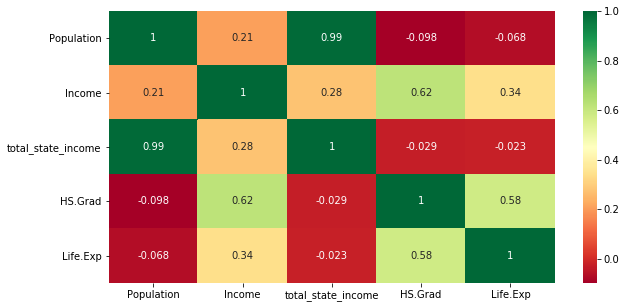

In [44]:
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(money.corr(),annot=True,cmap="RdYlGn");

На данной матрице видим очевидные зависимости: 

1) Population к total_state_income - что объяснимо: чем больше людей в штате, тем больше совокупный доход в штате.

2) Income к HS_Grad - тоже понятно: чем выше процент выпускников в штате, тем больше людей продолжают учиться дальше, получают профессию и, соответственно, тем самым увеличивают доход - как свой, так и штата.

3) Life_Exp к HS_Grad - предположительная длительность жизни зависит от уровня образованности. Что вполне понятно: образованный человек имеет больший доход и, соответственно, лучшее качество жизни. 

In [55]:
Population_top = money.groupby('state_abb')[['Population']].sum()\
    .sort_values('Population', ascending=False).head(5)
    
Population_top

Population
state_abb            
CA              21198
NY              18076
TX              12237
PA              11860
IL              11197

Самая большая численность населения - в Калифорнии

In [56]:
Population_antitop = money.groupby('state_abb')[['Population']].sum()\
    .sort_values('Population', ascending=True).head(5)
    
Population_antitop

Population
state_abb            
AK                365
WY                376
VT                472
DE                579
NV                590

Самая низкая популяция - в Аляске

In [57]:
Income_top = money.groupby('state_abb')[['Income']].sum()\
    .sort_values('Income', ascending=False).head(5)
    
Income_top

Income
state_abb        
AK           6315
CT           5348
MD           5299
NJ           5237
NV           5149

В Аляске не только численность населения низкая, но еще и доход населения высокий. Как и Невада - 5ая по малочисленности, но и занимает 5 место по уровню дохода.

In [58]:
Income_antitop = money.groupby('state_abb')[['Income']].sum()\
    .sort_values('Income', ascending=True).head(5)
    
Income_antitop

Income
state_abb        
MS           3098
AR           3378
LA           3545
NM           3601
WV           3617

В Миссисипе доход самый низкий у населения.

In [61]:
HS_Grad_top = money.groupby('state_abb')[['HS_Grad']].sum()\
    .sort_values('HS_Grad', ascending=False).head(5)
    
HS_Grad_top

HS_Grad
state_abb         
UT            67.3
AK            66.7
NV            65.2
CO            63.9
WA            63.5

Юта самый образованный штат. Но и Аляска с Невадой, не смотря на малочисленность штата, следуют сразу за Ютой.

In [63]:
HS_Grad_antitop = money.groupby('state_abb')[['HS_Grad']].sum()\
    .sort_values('HS_Grad', ascending=True).head(5)
    
HS_Grad_antitop

HS_Grad
state_abb         
SC            37.8
NC            38.5
KY            38.5
AR            39.9
GA            40.6

А вот в Южной Каролине грустно.

In [64]:
Life_Exp_top = money.groupby('state_abb')[['Life_Exp']].sum()\
    .sort_values('Life_Exp', ascending=False).head(5)
    
Life_Exp_top

Life_Exp
state_abb          
HI            73.60
MN            72.96
UT            72.90
ND            72.78
NE            72.60

На Гаваях люди живут дольше, чем в прочих штатах. И это неудивительно :))
    
Но интересно, что в данной выборке видим Юту, в которoй хороший уровень образования. 

In [65]:
Life_Exp_antitop = money.groupby('state_abb')[['Life_Exp']].sum()\
    .sort_values('Life_Exp', ascending=True).head(5)
    
Life_Exp_antitop

Life_Exp
state_abb          
SC            67.96
MS            68.09
GA            68.54
LA            68.76
NV            69.03

В Южной Каролине не только самый низкий уровень образованности, так и продолжительность жизни - ниже всех прочих штатов.

In [88]:
#для наглядности выведем все штаты и все данные по ним
money.style.bar()

Изучив основные данные из датасета money, можно перейти к climate.

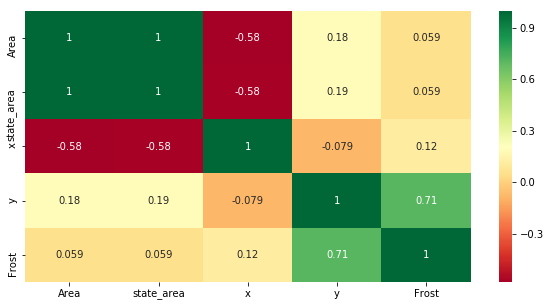

In [67]:
#посмотрим взаимосвязи
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(climate.corr(),annot=True,cmap="RdYlGn");

Что видно сразу - очевидная зависимость количества холодных дней от y (широта), при этом от x (долготы) температура зависит мало. 

Посмотрим холодные и теплые штаты.

In [68]:
Frost_top = climate.groupby('state_abb')[['Frost']].sum()\
    .sort_values('Frost', ascending=False).head(5)
    
Frost_top

Frost
state_abb       
NV           188
ND           186
NH           174
WY           173
SD           172

Странно не видеть Аляску в топ самых холодных штатов (забегая вперед, у Аляски 152 дня в году холодных дней). Невада с высоким уровнем образования и высоким доходом на душу населения, но еще и самый холодный и малонаселенный штат. 

In [69]:
Frost_free = climate.groupby('state_abb')[['Frost']].sum()\
    .sort_values('Frost', ascending=True).head(5)
    
Frost_free

Frost
state_abb       
HI             0
FL            11
LA            12
AZ            15
AL            20

Гаваи - климатический рай, где живут долгожители. Интересная зависимость - чем теплее, тем дольше продолжительность жизни.

Посмотрим и сравним штаты по широте.

In [70]:
y_north = climate.groupby('state_abb')[['y']].sum()\
    .sort_values('y', ascending=False).head(5)
    
y_north

y
state_abb         
AK         49.2500
WA         47.4231
ND         47.2517
MT         46.8230
MN         46.3943

Здесь мы видим, что не смотря на то, что Аляска - не самый холодный штат, все же является самым северным штатом.

In [71]:
y_south = climate.groupby('state_abb')[['y']].sum()\
    .sort_values('y', ascending=True).head(5)
    
y_south

y
state_abb         
FL         27.8744
LA         30.6181
TX         31.3897
HI         31.7500
GA         32.3329

По результатам анализа широты - все самые теплые штаты находятся на юге и в них продолжительность жизни - выше прочих.

In [89]:
#для наглядности выведем все штаты и все данные по ним
climate.style.bar()

Перейдем к криминальной составляющей. Проанализируем датасет criminal.

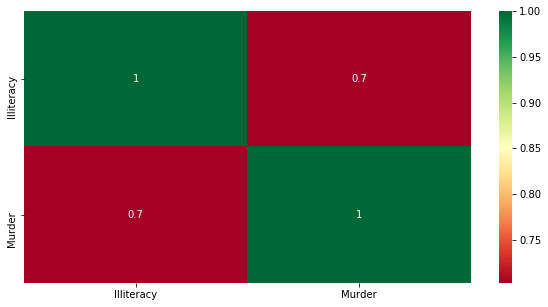

In [72]:
#посмотрим взаимосвязи
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(criminal.corr(),annot=True,cmap="RdYlGn");

Корреляция между неграмотностью и уровнем убийств - очевидна.

In [74]:
Illiteracy = criminal.groupby('state_abb')[['Illiteracy']].sum()\
    .sort_values('Illiteracy', ascending=False).head(5)
Illiteracy

Illiteracy
state_abb            
LA                2.8
MS                2.4
SC                2.3
TX                2.2
NM                2.2

Лидер по безграмотности - Луизианна. Дальше знакомые по антирейтингу - Миссисипи, Северная Каролина. 

In [75]:
Illiteracy_min = criminal.groupby('state_abb')[['Illiteracy']].sum()\
    .sort_values('Illiteracy', ascending=True).head(5)
Illiteracy_min

Illiteracy
state_abb            
SD                0.5
NV                0.5
IA                0.5
WY                0.6
NE                0.6

Южная Дакота - лидер по отсутствию безграмотности, за ней следуют Невада (известная по высоким рейтингам по прочим параметрам).

In [76]:
Murder = criminal.groupby('state_abb')[['Murder']].sum()\
    .sort_values('Murder', ascending=False).head(5)
Murder

Murder
state_abb        
AL           15.1
GA           13.9
LA           13.2
MS           12.5
TX           12.2

In [103]:
Murder_min = criminal.groupby('state.abb')[['Murder']].sum()\
    .sort_values('Murder', ascending=True).head(5)
Murder_min

Murder
state.abb        
ND            1.4
SD            1.7
MN            2.3
IA            2.3
RI            2.4

In [90]:
#для наглядности выведем все штаты и все данные по ним
criminal.style.bar()

Для наглядности вышеизложенной информации по анализу составим дашборды:

Влияние климата на численность населения и продолжительность жизни: https://datastudio.google.com/reporting/c3f58680-2648-4539-8ab0-09a16c664ba6/page/XNwCB


Зависимость дохода от уровня образованности: https://datastudio.google.com/reporting/f00ecd53-bf35-491b-8f1c-19122c22d902/page/1dxCB

Взаимосвязь штатов с низкой грамотностью населения и количеством тяжких преступлений: https://datastudio.google.com/reporting/5c602876-1369-4d22-a6b9-ca06902a651d/page/7eyCB
    